# ctDNA changes as a predictive marker for response (PR/CR/SD/PD) (UMCG/Paul and Hylke, validation at MUG)

In [1]:
from matplotlib import pyplot as plt
from sklearn.linear_model import LogisticRegression

from pipelines import pipeline_Freeman
from transform import combine_tsv_files, generate_data_pairs, generate_model_data_pairs
from views import compare_prognostic_value_genomic_information, view_linear_model_freeman

# Model: Logistic regression with $L_2$ regularisation

In [32]:
# Parameters for logistic regression.
random_state = 1234
model_parameters = {
            "random_state": random_state,
            "solver": "newton-cg",
            "penalty": "l2",
            "class_weight": "balanced",
            "multi_class": "auto",
            "C": 0.025,
            "max_iter": 5000,
}
model = LogisticRegression(**model_parameters)

## In how many patients did we observe consistent increase/decrease of ctDNA levels? How many patients showed a mixed molecular response?
Figure of Paul

## Can changing levels predict response?
Marginally:

In [27]:
# Difference genomic variable.
X_train_t0, y_train = combine_tsv_files(
    "output/train__gene__t0__No. Mutant Molecules per mL.tsv",
    "output/train__gene__t0__CNV Score.tsv",
)

In [28]:
y_train = y_train["response_grouped"]

response_labels = ['non responder (sd+pd)', 'responder (pr+cr)', 'non evaluable (ne)']
pos_label = 'responder (pr+cr)'
y_train = y_train == pos_label

In [29]:
logistic_Freeman = pipeline_Freeman(estimator=model)
logistic_Freeman

Pipeline(memory=None,
         steps=[('clinical_curation',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function clinical_data_curation at 0x7febf632c400>,
                                     inv_kw_args=None, inverse_func=None,
                                     kw_args=None, pass_y='deprecated',
                                     validate=False)),
                ('filter_clinical_variables',
                 FunctionTransformer(accept_sparse=False, check_inverse=True,
                                     func=<function d...
                                                   'lymfmeta', 'brainmeta',
                                                   'adrenalmeta', 'livermeta',
                                                   'lungmeta', 'skeletonmeta',
                                                   'age'])],
                                   verbose=False)),
                ('estimator',
        

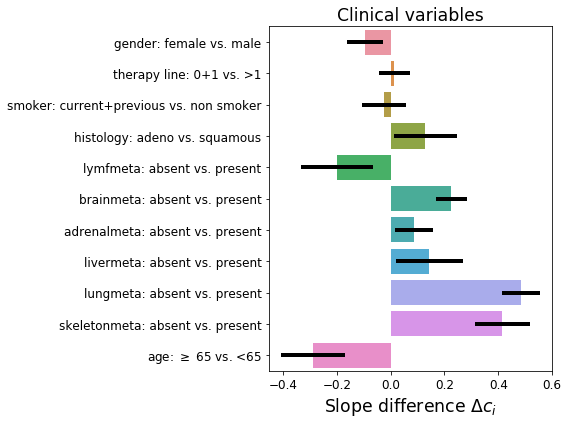

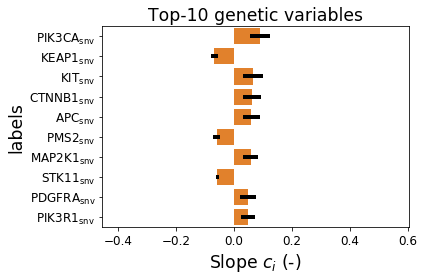

In [30]:
figure_filenames = ("logistic_regression__clinical_freeman__t0", "logistic_regression__genetic_freeman__t0")
view_linear_model_freeman(
    X_train_t0, 
    y_train, 
    logistic_Freeman, 
    filenames=figure_filenames, 
)

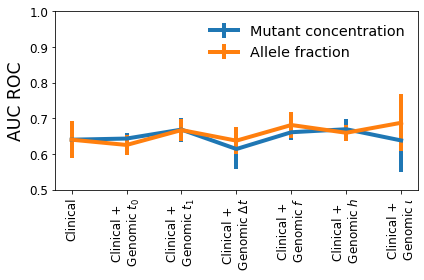

In [31]:
mutant_data_pairs = generate_data_pairs(
    filename_prefix="output/train__gene", snv_type="No. Mutant Molecules per mL"
)
vaf_data_pairs = generate_data_pairs(
    filename_prefix="output/train__gene", snv_type="Allele Fraction"
)
model_mutant_data_pairs = generate_model_data_pairs(mutant_data_pairs, model_parameters)
model_vaf_data_pairs = generate_model_data_pairs(vaf_data_pairs, model_parameters)
compare_prognostic_value_genomic_information(model_mutant_data_pairs, plot_label="Mutant concentration")
compare_prognostic_value_genomic_information(model_vaf_data_pairs, plot_label='Allele fraction')
plt.savefig('figs/comparison_genomic_data.png', bbox_inches="tight")

## Do baseline levels correlate with response
See figure:
![VAF/mol](figs/comparison_genomic_data.png "VAF molecules comparison")

## Define a cut-off for quantitative change or for baseline levels!
## Use mean of all variants
## Use a delta (T0-T1) of 30% as cut-off
## Use a delta (T0-T1) of 50% as cut-off
## Use a delta (T0-T1) of 80% as cut-off
## Consider only variants with VAF <0.5%
## Consider only variants with VAF <1%
## Use “highest” only
## Use cases with consistent vs mixed changes in levels
## Use all variants including synonymous
## Use only variants excluding synonymous

## Check whether VAF OR mutant molecules/ml is a better predictor
See figure:
![VAF/mol](figs/comparison_genomic_data.png "VAF molecules comparison")